# Biomedical Signal Pre-Processing Tutorial

### What is the goal of biomedical signal pre-processing?

The goal of preprocessing is to improve the quality and usability of the signals for subsequent analysis or modeling tasks.

### Can I skip this and just feed the data to train an AI model?

Only if the data is clean, which is rarely the case. As we will see, the data can be corrupted by many sources of noise.

*Note*: Even if the data is totally clean, it may still need to be normalized before being fed to train an AI model.

### What are the goals of this workshop?

- Highlight the importance of Biomedical Signal Pre-Processing
- Introduce common techniques used for treating biological signals before it can be used in AI models.
- Introduce common libraries, best practices, and code snippets in Python

### Step 1: Setting up your environment

First, ensure you have the necessary Python libraries installed. If not, you can install them using pip.

### Parenthesis: Virtual Environments in Python

Creating virtual environments in software development, particularly in Python, is a fundamental practice that significantly enhances project management, collaboration, and deployment by isolating dependencies. A virtual environment is a self-contained directory that contains a Python installation for a particular version of Python, plus a number of additional packages.


#### Creating a Virtual Environment

Here's how to create a virtual environment in Python using `venv` (standard library in Python 3.3 and later):

1. **Install Python:** Ensure Python is installed on your system. It's recommended to use the latest version for improved features and security.


2. **Create a Virtual Environment:**
   - Open a terminal or command prompt.

   - Run the command to create a virtual environment: `python3 -m venv env` (The `env` is the name of the virtual environment directory; you can name it anything you like).
   - Navigate to your project directory: `cd path/to/your-project`.


3. **Activate the Virtual Environment:**
   - On Windows: `.\env\Scripts\activate`
   - On macOS/Linux: `source env/bin/activate`
   - Once activated, your terminal prompt will usually change to indicate that you are now working within the virtual environment.


4. **Install Dependencies:** With the virtual environment activated, use `pip` to install any dependencies required for your project: `pip install package_name`.

5. **Deactivate:** When you're done working in the virtual environment, you can deactivate it by running: `deactivate`.


Ideally, you would do this **before** starting the Jupyter Notebook, and you create the notebook within that environment.

In [190]:
#pip install scipy matplotlib numpy

Now import the python libraries

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

### Step 2: Loading Biomedical Signals
We'll use the ECG data available in the SciPy library for this tutorial. Let's load the data and visualize it to understand its initial state.

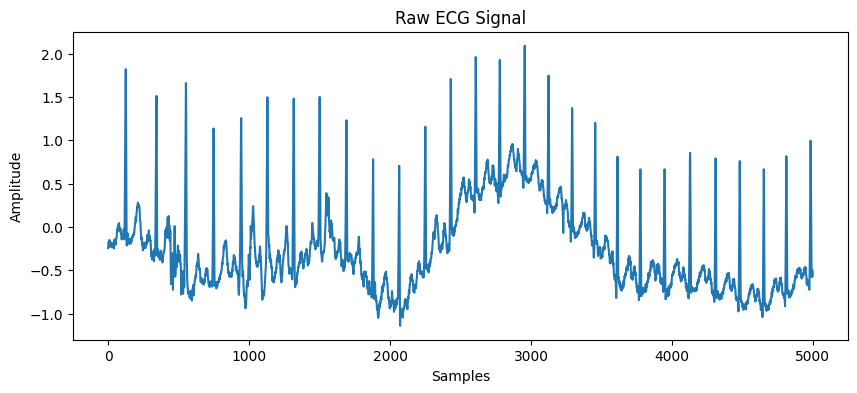

In [192]:
from scipy.datasets import electrocardiogram

# Load the ECG data
ecg = electrocardiogram()

# Plot the first 5000 samples
plt.figure(figsize=(10, 4))
plt.plot(ecg[:5000])
plt.title('Raw ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

### How many seconds of data does this correspond to?

--> Note the Sampling Frequency!

The sampling frequency, also known as the sampling rate, is the number of samples of a signal taken per second to digitally represent the signal. It is measured in Hertz (Hz). For example, a sampling frequency of 512 Hz means the signal is sampled 512 times in one second.

Nyquist Theorem: According to the Nyquist-Shannon sampling theorem, to accurately reconstruct a continuous signal from its samples without losing information, the sampling frequency must be at least twice the highest frequency present in the signal (the Nyquist rate). Sampling at a rate below this can lead to aliasing, where high-frequency components of the signal are incorrectly represented as lower frequencies.

In this example, the sampling frequency is equal to 360Hz

In [219]:
fs = 360
length_of_signal = len(ecg)/fs
print(f"This signal is of length {length_of_signal} s")

This signal is of length 300.0 s


## Step 3: Noise Rejection

### Can you spot an artifact?

**Advice**: Always visualize the data that you are working with.

Note the baseline wander! This is one of the most common artifacts that are present in biomedical signals.

Baseline wander refers to the low-frequency fluctuation observed in a signal, typically caused by the movement or shifting of the baseline of the signal.

Baseline wander can occur due to various reasons, including:

- Respiration: In ECG signals, baseline wander can occur due to the respiratory cycle. The movement of the chest during breathing can cause shifts in the baseline of the ECG signal.

- Electrode Motion or Displacement: Movements of the electrodes attached to the patient's body can lead to baseline variations.

- Skin Impedance Changes: Variations in skin impedance can also affect the baseline of the signal.

Baseline wander can obscure the underlying features of the signal and make it difficult to analyze. Therefore, it is essential to remove or mitigate baseline wander before further processing or analysis of the signal. Techniques such as high-pass filtering, baseline drift correction algorithms, and adaptive filtering methods are commonly used to remove baseline wander from biomedical signals.

### How to remove the baseline wander?

To remove baseline wander from the ECG data, you can use a high-pass filter, as the baseline wander is a very slow signal. The scipy.signal library provides functions to design and apply filters. We will design a filter to remove all frequencies that are below 0.5Hz.

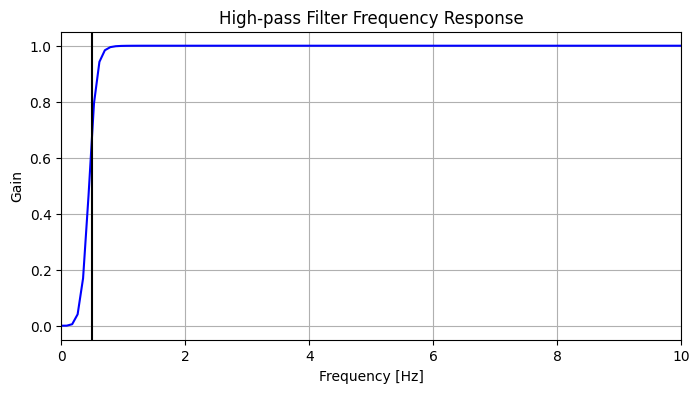

In [194]:
from scipy.signal import freqz

# Design the Butterworth high-pass filter
order = 5  # Order of the filter
cutoff_frequency = 0.5  # Cutoff frequency in Hz
b, a = scipy.signal.butter(
    order, cutoff_frequency, btype='high', fs=fs)

# Compute the frequency response
w, h = freqz(b, a, worN=2048)

# Plot the frequency response
plt.figure(figsize=(8, 4))
plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.axvline(cutoff_frequency, color='k')
plt.xlim(0, 10)
plt.title("High-pass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()

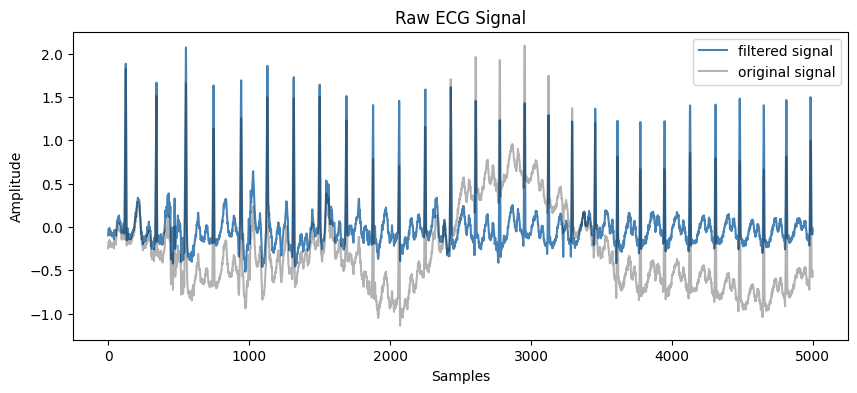

In [195]:
# Filter the ECG Signal
ecg_filtered = scipy.signal.filtfilt(b, a, ecg)

# You can now use `ecg_filtered` for further analysis

# Plot the first 5000 samples
plt.figure(figsize=(10, 4))
plt.plot(
    ecg_filtered[:5000], color='steelblue', label='filtered signal')
plt.plot(
    ecg[:5000], color='black', alpha=0.3, label='original signal')
plt.title('Raw ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Let's look at the frequency content of our ECG signal. We will compute the power spectral density (PSD) of a signal using Welch's method. The PSD of a signal quantifies the strength of the signal's frequency components and helps identify dominant frequencies, noise characteristics, and spectral features.

### What does it mean "frequency content of a signal?"

It refers to the distribution of different frequencies that make up the signal. Every complex signal can be thought of as being composed of multiple sine waves of varying frequencies, amplitudes, and phases.

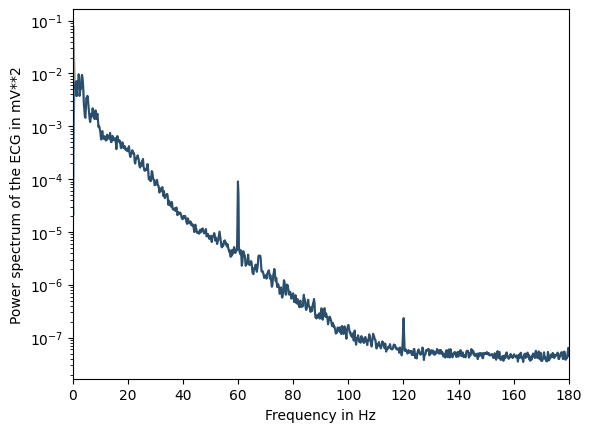

In [196]:
f, Pxx = scipy.signal.welch(
    ecg,
    fs=fs,
    nperseg=2048,
    noverlap=1024,
    scaling="spectrum")

f, Pxx_filtered = scipy.signal.welch(
    ecg_filtered,
    fs=fs,
    nperseg=2048,
    noverlap=1024,
    scaling="spectrum")

plt.semilogy(f, Pxx_filtered, label='filtered signal', color='steelblue')
plt.semilogy(f, Pxx, label='original signal', color='black', alpha=0.4)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

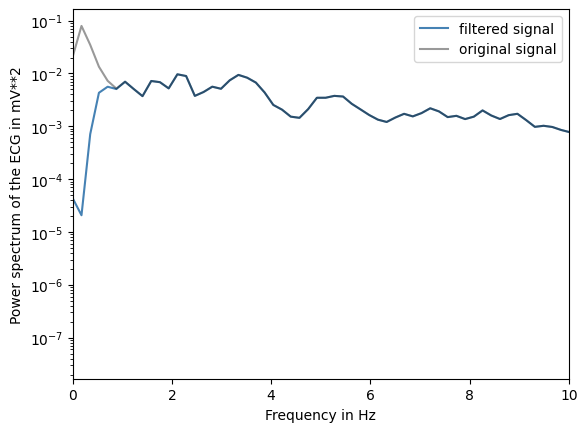

In [197]:
# Let's take a look closer at the lower frequency range

plt.semilogy(f, Pxx_filtered, label='filtered signal', color='steelblue')
plt.semilogy(f, Pxx, label='original signal', color='black', alpha=0.4)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim([0, 10])
plt.legend()
plt.show()

Q: Why is the plot only showing up to 180Hz?

As the signal is sampled at 360Hz, then the Nyquist frequency is 180Hz, meaning that we are only able to capture data that goes up to 180Hz.

### Going back to the original plot, What do we notice?

1. The plot shows a general decrease in power as the frequency increases, which is typical for physiological signals like ECG. Most of the energy in an ECG signal is concentrated at lower frequencies.

2. Power Line Interference at 60Hz: This is one of the most common artifacts that you see in Biomedical Signal Processing.

Power line interference in biomedical signal processing refers to the unwanted electrical noise that originates from the electrical power supply network. This interference is typically found at the frequency of the electrical power grid, which is 50 Hz in many countries around the world, including most of Europe, Asia, Africa, and Australia, and 60 Hz in North America and parts of South America.

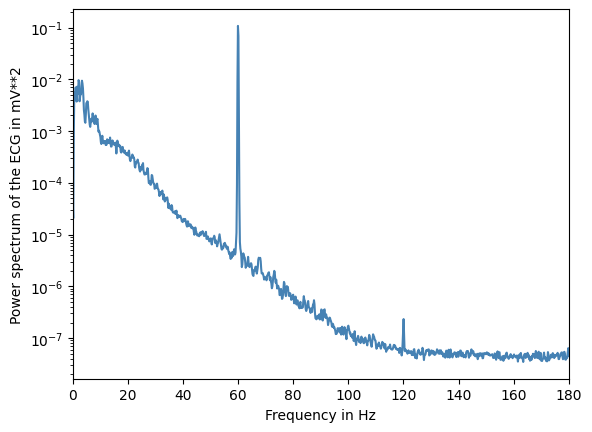

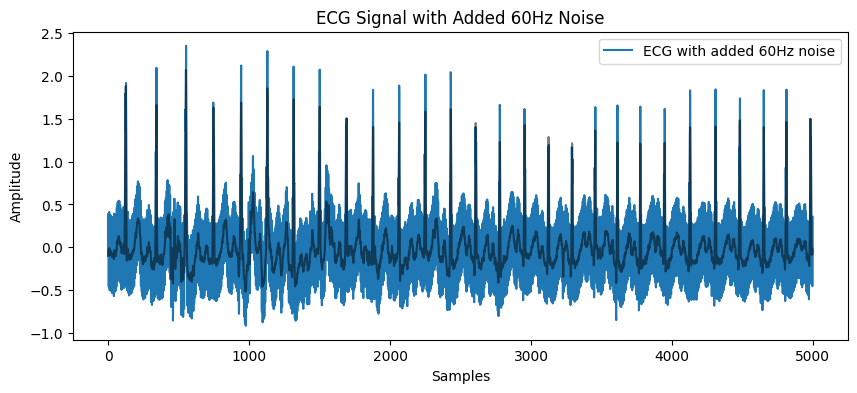

In [198]:
t = np.arange(len(ecg_filtered)) / fs  # Time vector

# Create a 60Hz sinusoidal noise signal
noise_frequency = 60  # Noise frequency in Hz
amplitude = 0.5  # Adjust the amplitude of the noise as needed
noise = amplitude * np.sin(2 * np.pi * noise_frequency * t)

# Add the noise to the ecg_filtered signal
ecg_filtered_noisy = ecg_filtered + noise

f, Pxx_filtered_noisy = scipy.signal.welch(
    ecg_filtered_noisy,
    fs=fs,
    nperseg=2048,
    noverlap=1024,
    scaling="spectrum")

plt.semilogy(f, Pxx_filtered_noisy, label='filtered signal', color='steelblue')
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

# Plotting the noisy signal
plt.figure(figsize=(10, 4))
plt.plot(ecg_filtered_noisy[:5000], label='ECG with added 60Hz noise')
plt.plot(ecg_filtered[:5000], alpha=0.5, color='black')
plt.legend()
plt.title('ECG Signal with Added 60Hz Noise')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

### How do we remove this 60Hz noise?

We use something called a Notch Filter

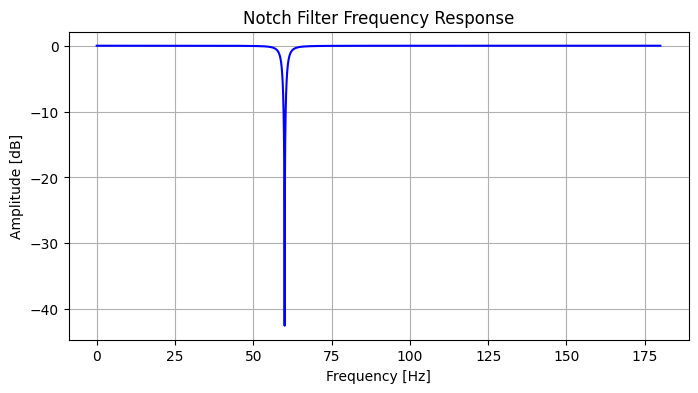

In [199]:
# Parameters
f0 = 60  # Frequency to be removed, i.e., power line frequency
quality_factor = 30  # Quality factor, higher values mean a narrower notch

# Design the notch filter
b, a = scipy.signal.iirnotch(f0, quality_factor, fs)


# Compute the frequency response
w, h = freqz(b, a, worN=8000)

# Plot the frequency response
plt.figure(figsize=(8, 4))
plt.plot(fs * w / (2 * np.pi), 20 * np.log10(abs(h)), 'b')
plt.title("Notch Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid(True)
plt.show()



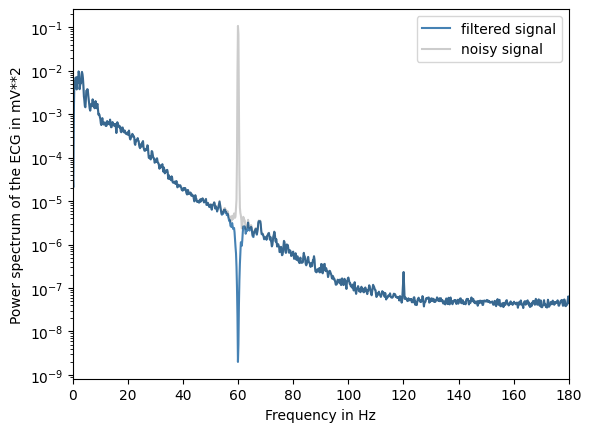

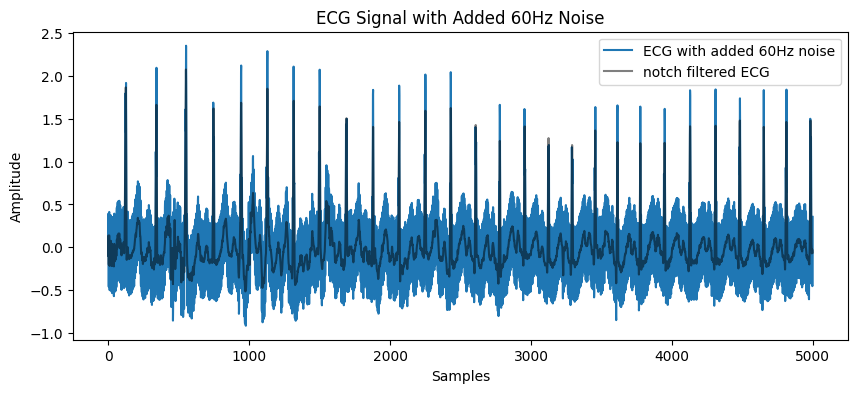

In [200]:
# Apply the filter to the ECG signal
ecg_notched = scipy.signal.filtfilt(b, a, ecg_filtered_noisy)

# ecg_notched is the filtered ECG signal with reduced power line interference
f, Pxx_notched = scipy.signal.welch(
    ecg_notched,
    fs=fs,
    nperseg=2048,
    noverlap=1024,
    scaling="spectrum")

plt.semilogy(f, Pxx_notched, label='filtered signal', color='steelblue')
plt.semilogy(f, Pxx_filtered_noisy, label='noisy signal', color='black', alpha=0.2)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.legend()
plt.show()

# Plotting the notch filtered signal
plt.figure(figsize=(10, 4))
plt.plot(ecg_filtered_noisy[:5000], label='ECG with added 60Hz noise')
plt.plot(ecg_notched[:5000], alpha=0.5, color='black', label='notch filtered ECG')
plt.title('ECG Signal with Added 60Hz Noise')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


### Other sources of noise:

- Muscle Artifacts
- Electrode Pop or Contact Noise
- Motion Artifacts
- Sweat Artifacts
- Enviromental Noise
- Etc.

It is very common practice to **band-pass** the signals and only keep "frequencies of interest".

Electrocardiogram (ECG):  measures the electrical activity of the heart. The key features are found in the range of 0.05 Hz to 40 Hz.

Photoplethysmography (PPG): measures changes in blood volume in the tissue, often used to estimate heart rate. the frequency range of interest is typically between 0.5 Hz and 5 Hz.

Electroencephalogram (EEG): measures electrical activity in the brain. In Scalp EEG, typically frequenies of interest are up to 40Hz, but that can go higher with more invasive EEG.

Let's low-pass our ECG data with cutoff frequency at 40Hz

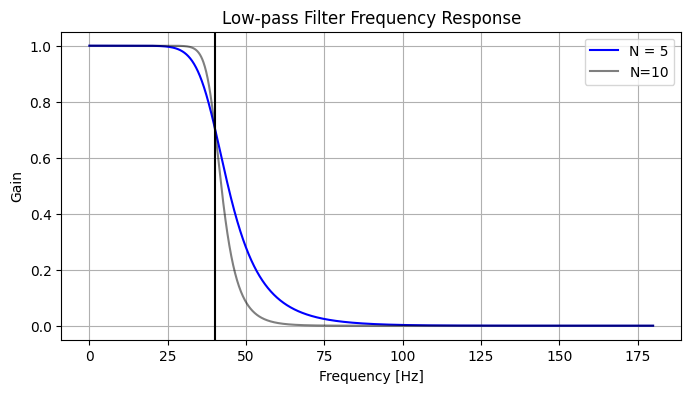

In [201]:
cutoff_frequency = 40
b, a = scipy.signal.butter(
    Wn=cutoff_frequency, N=5, btype='low', fs=fs)

b2, a2 = scipy.signal.butter(
    Wn=cutoff_frequency, N=10, btype='low', fs=fs)

#  Note the btype='low' here in comparison to 'high' we used earlier
#  What is the difference between using N=5 or N=10

# Compute the frequency response
w, h = freqz(b, a, worN=2048)
w2, h2 = freqz(b2, a2, worN=2048)

# Plot the frequency response
plt.figure(figsize=(8, 4))
plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b', label='N = 5')
plt.plot(0.5 * fs * w2 / np.pi, np.abs(h2), 'black', alpha=0.5, label='N=10')
plt.axvline(cutoff_frequency, color='k')
plt.title("Low-pass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.legend()
plt.grid()
plt.show()

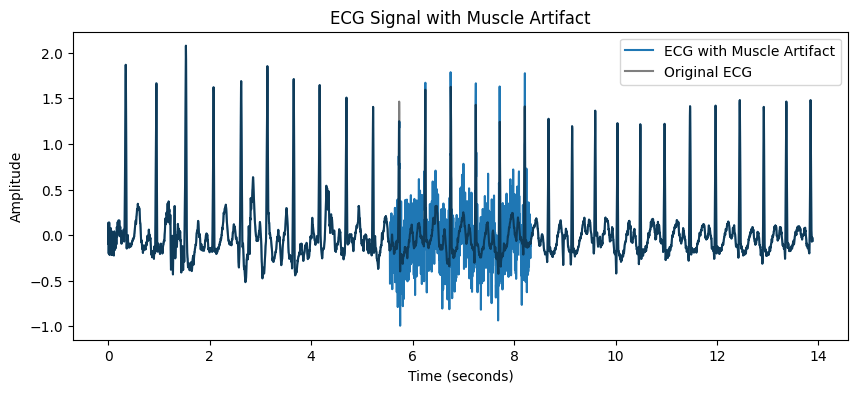

In [202]:
# Simulate muscle artifact noise
# Muscle artifacts are typically random high-frequency noise, so we can simulate this with random noise
# Adjust the amplitude as needed to simulate the strength of the muscle artifact
amplitude = 0.25 # Adjust this value based on the desired artifact strength

# Initialize muscle_artifact array with zeros
muscle_artifact = np.zeros(len(ecg_notched))

# Generate random noise only for a portion of the signal (between samples 1000 and 3000)
muscle_artifact[2000:3000] = amplitude * np.random.randn(1000)


# Add the muscle artifact to the ecg_notched signal
ecg_notched_with_muscle_artifact = ecg_notched + muscle_artifact

# Plotting the signal with muscle artifact
plt.figure(figsize=(10, 4))
plt.plot(t[:5000], ecg_notched_with_muscle_artifact[:5000], label='ECG with Muscle Artifact')
plt.plot(t[:5000], ecg_notched[:5000], color='black', label='Original ECG', alpha=0.5)
plt.title('ECG Signal with Muscle Artifact')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

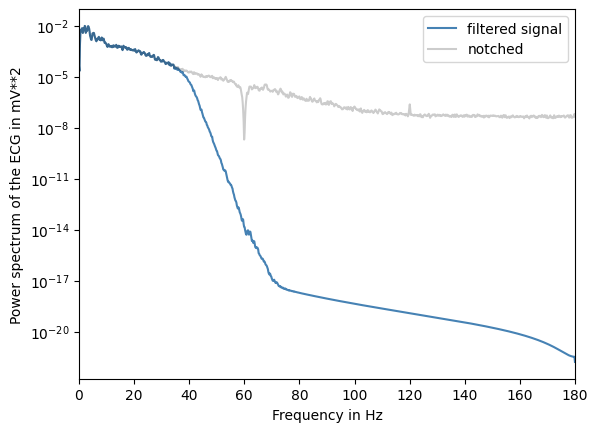

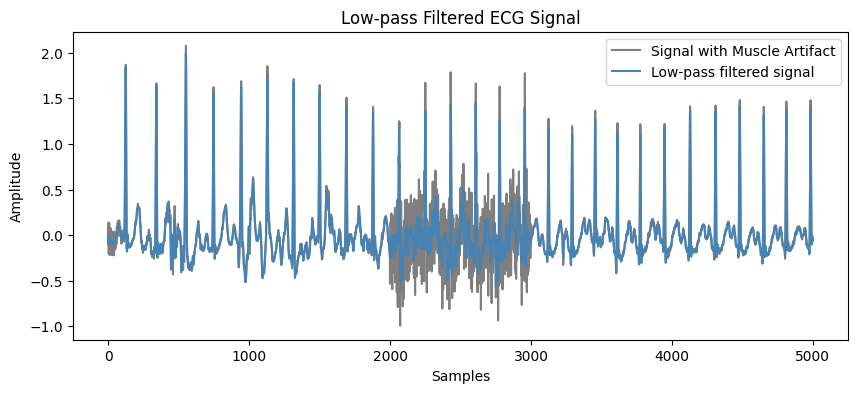

In [203]:
ecg_filtered = scipy.signal.filtfilt(
    b2, a2, ecg_notched_with_muscle_artifact)

# ecg_notched is the filtered ECG signal with reduced power line interference
f, Pxx_filtered= scipy.signal.welch(
    ecg_filtered,
    fs=fs,
    nperseg=2048,
    noverlap=1024,
    scaling="spectrum")

plt.semilogy(f, Pxx_filtered, label='filtered signal', color='steelblue')
plt.semilogy(f, Pxx_notched, label='notched', color='black', alpha=0.2)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.legend()
plt.show()


# Plotting the filtered signal
plt.figure(figsize=(10, 4))
#plt.plot(ecg_notched[:5000], label='Notched signal', color='black', alpha=0.5)
plt.plot(ecg_notched_with_muscle_artifact[:5000], label='Signal with Muscle Artifact', color='black', alpha=0.5)
plt.plot(ecg_filtered[:5000], label='Low-pass filtered signal', color='steelblue')
plt.title('Low-pass Filtered ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Note: Muscle Artifacts are tricky to remove, since they affect a range of frequencies that include the frequencies of interest, typically 20-150Hz.

Now we can calculate features on the ECG signal! A very popular feature is the Heart-Rate.

To calculate the heart rate from the ECG data, you can follow these steps:

1. **Detect R-peaks**: The R-peaks in an ECG signal represent the point of maximum upward deflection during a heartbeat and are used to calculate the heart rate.

2. **Calculate RR Intervals**: The RR interval is the time between successive R-peaks. It's usually measured in seconds.

3. **Calculate Heart Rate**: The heart rate can be calculated from the RR intervals.

In [220]:

def calculate_hr(ecg, min_distance=0.2*fs, height=0.5):
    # Detect R-peaks
    peaks, _ = scipy.signal.find_peaks(
        ecg, distance=min_distance, height=height)  # Adjust the distance parameter as needed

    # Calculate RR intervals
    rr_intervals = np.diff(peaks) / fs  # in seconds

    # Calculate average heart rate
    average_rr_interval = np.mean(rr_intervals)
    heart_rate = 60 / average_rr_interval  # in beats per minute (BPM)

    return peaks, heart_rate

r_peaks, heart_rate = calculate_hr(ecg_filtered)
print(f"Average Heart Rate: {heart_rate:.2f} BPM")



Average Heart Rate: 102.64 BPM


In [205]:
#pip install plotly

# Plotly is a package that allows you to interact
# with figures in a jupyter notebook

In [206]:
import plotly.graph_objects as go

def plot_ecg(ecg_signal, r_peaks=None, use_plotly=False):
    if use_plotly:
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(y=ecg_signal, mode='lines', name='ECG Signal'))
        if r_peaks is not None:
            fig.add_trace(go.Scatter(x=r_peaks, y=ecg_signal[r_peaks], mode='markers', marker=dict(color='red', size=8), name='R-peaks'))
        fig.update_layout(title='ECG Signal with R-peaks' if r_peaks is not None else 'ECG Signal', xaxis_title='Sample', yaxis_title='Amplitude')
        fig.show()
    else:
        plt.figure(figsize=(10, 4))
        plt.plot(ecg_signal, label='ECG Signal')
        if r_peaks is not None:
            plt.plot(r_peaks, ecg_signal[r_peaks], 'ro', label='R-peaks')
        plt.legend()
        plt.show()

In [207]:
plot_ecg(ecg_filtered, r_peaks, use_plotly=True)

Often you don't want to calculate the feature on the entire recording, rather you want to segment the signal and calculate the features on these segments.


In [222]:
win_size_s = 30  # Interval length in seconds

# Calculate the number of samples per interval
win_size = win_size_s * fs

# Calculate the total number of intervals in the ecg_filtered signal
total_samples = len(ecg_filtered)
total_intervals = total_samples // win_size

# Initialize an empty list to store the heart rates
heart_rates = []

# Segment your ECG 
# Number of segments
num_segments = len(ecg_filtered) // win_size

# Reshape the ECG signal into a 2D array of segments
# Each row represents a segment
ecg_segments = ecg_filtered[:num_segments * win_size].reshape((num_segments, win_size))

# ecg_segments is now an array where each row is a 30-second segment of the ECG signal

#  It is very important here to check that your segments do not
#  contain high amounts of noise, one way to do it is to calculate the
#  standard deviation of each segment, and reject those than have a very high
#  standard deviation compared to the average

#  Windows containing high amplitude noise are outliers and will
#  severly limit your ability to train AI models

std_segments = np.std(ecg_segments, axis=1)
max_segments = np.max(ecg_segments, axis=1)
noisy_segments = std_segments > np.mean(std_segments) * 4
print(f"Noisy Segments: {np.nonzero(noisy_segments)[0]}")

# You can also use a simpoe noise threshold
noise_max = 3
noisy_segments = (noisy_segments) | (max_segments > noise_max)


# Loop through each interval and calculate the heart rate
for i in range(num_segments):
    segment = ecg_segments[i]
    # Use the calculate_hr function on the segment
    _, hr = calculate_hr(segment)
    heart_rates.append(hr)

Noisy Segments: []


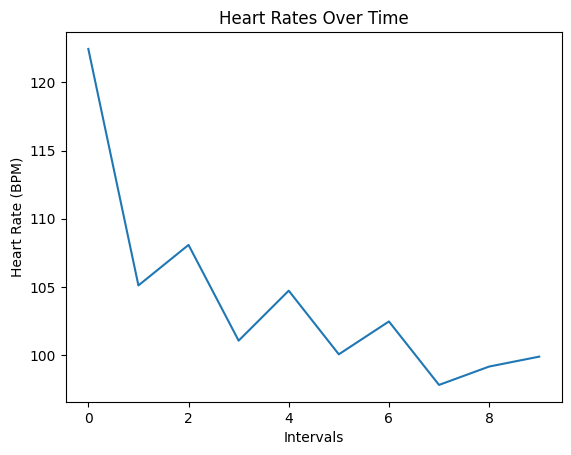

In [209]:
plt.plot(heart_rates)
plt.title('Heart Rates Over Time')
plt.xlabel('Intervals')
plt.ylabel('Heart Rate (BPM)')
plt.show()

### Honorable Mention: Data Interpolation

Sometimes, samples in your signal might be missing, due to disconnects or other reasons, which will result in NaNs being present in your signal.

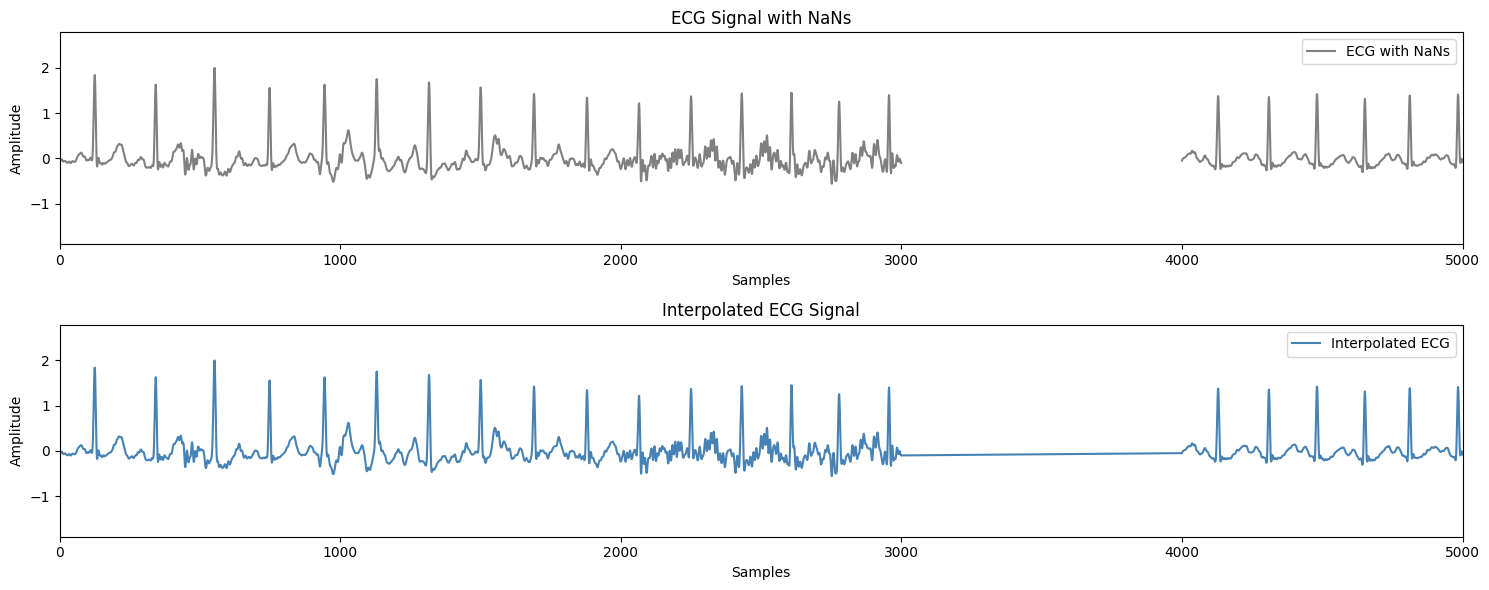

In [210]:
# Assuming 'ecg' is your original ECG signal
# First, let's create a copy of the ECG signal to modify
ecg_with_nans = np.copy(ecg_filtered)

# Insert NaNs between samples 3000 and 4000
ecg_with_nans[3000:4000] = np.nan

# Find indices of NaNs and non-NaNs
nans = np.isnan(ecg_with_nans)
not_nans = ~nans

# Time vector for interpolation
time = np.arange(len(ecg_with_nans))

# Interpolate to fill NaNs
interpolator = scipy.interpolate.interp1d(
    time[not_nans], ecg_with_nans[not_nans], kind='linear', fill_value="extrapolate")
ecg_interpolated = interpolator(time)

# Plotting
plt.figure(figsize=(15, 6))

# Plot original signal with NaNs
plt.subplot(2, 1, 1)
plt.plot(ecg_with_nans, label='ECG with NaNs', color='grey')
plt.title('ECG Signal with NaNs')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.xlim([0, 5000])
plt.legend()

# Plot interpolated signal
plt.subplot(2, 1, 2)
plt.plot(ecg_interpolated, label='Interpolated ECG', color='steelblue')
plt.title('Interpolated ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.xlim([0, 5000])

plt.tight_layout()
plt.show()

Note: Make sure to reject windows that contain a large percentage of NaNs!

### Optional:  Data Normalization

Sometimes, you will need to normalize your data to make sure all of your data is on the same scale. This is especially important if your data is coming from different sensors or different sources.

## Part 2: Eyes-Open vs Eyes-Closed Classifier using EEG

In this part of the workshop, we will briefly take a look at pre-processing an EEG signal and detecting Eyes-Open vs Eyes-Closed.

Download the data from https://zenodo.org/records/2348892, you can choose to only download subject_02.mat from V1 for this workshop

In [226]:
#  Load the .mat file

import scipy.io as sio
eeg = sio.loadmat('subject_02.mat')['SIGNAL']

Let's take a look at the frequency content of this signal

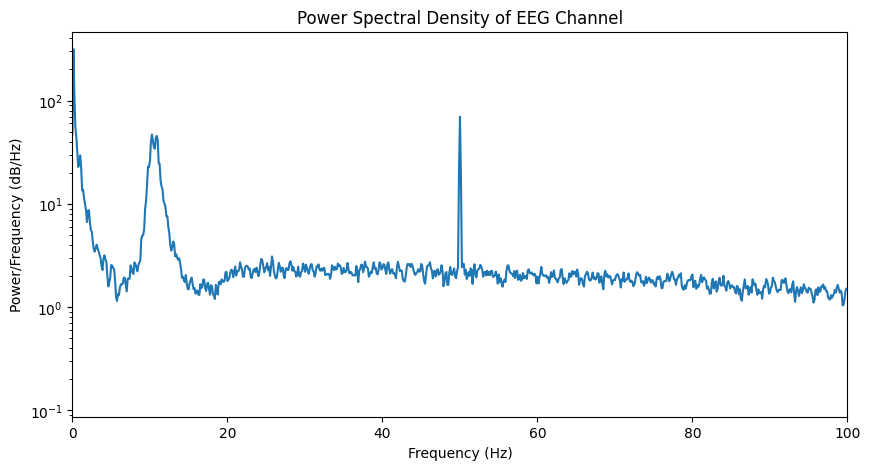

In [212]:
fs_eeg = 512

# Select a channel to analyze, for example, channel 16
eeg_channel = eeg[:, 16]

# Calculate the Power Spectral Density (PSD) using Welch's method
frequencies, psd = scipy.signal.welch(
    eeg_channel, fs=fs_eeg, nperseg=4096)

# Plotting the PSD
plt.figure(figsize=(10, 5))
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density of EEG Channel')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.xlim([0, 100])
plt.show()

Note the power line noise at 50Hz, which means that this EEG was not recorded in North America.

For Scalp EEG, these are the frequencies of interest:

- Delta waves: 0.1 - 4 Hz (deep sleep)
- Theta waves: 4 - 8 Hz (drowsiness, memory)
- Alpha waves: 8 - 13 Hz (relaxed wakefulness)
- Beta waves: 13 - 30 Hz (alertness, concentration)
- Gamma waves: 30 - 100 Hz (higher cognitive functions) - but note that for scalp EEG, frequencies above ~40Hz are attenuated.

##  A popular step but use with caution: Downsampling

Downsampling reduces the amount of data by decreasing the sampling rate, making storage, handling, and processing more manageable and efficient without significantly compromising the signal's integrity for the intended analysis.

Caution: It's important to note that downsampling should be done carefully to avoid losing critical information. The choice of the new sampling rate should consider the signal's bandwidth and the information of interest to ensure that the downsampled signal still accurately represents the original signal for the intended analysis.

Caution: Make sure there are no frequencies that are above 2x the Nyquist frequency. For example, if we are downsampling from 512 Hz to 256 Hz, we need to filter all data that is above the Nyquist frequency of the 256Hz, which is 128 Hz, to prevent aliasing.

In [213]:
# Assuming 'eeg_channel' is your signal and 'fs_eeg' is the current sampling frequency
# Let's say you want to downsample by a factor of 2
decimation_factor = 2

# Downsample the signal
# Note about the decimate function: it filters the data to prevent aliasing!
eeg_channel_downsampled = scipy.signal.decimate(
    eeg_channel, decimation_factor)

# Update the sampling frequency
fs_eeg_downsampled = fs_eeg / decimation_factor

# You can now work with 'eeg_channel_downsampled' and 'fs_eeg_downsampled' for further analysis

In [223]:
# Print the initial length of the signal
print(f"Initial length of the signal: {len(eeg_channel)}")
# Print the downsampled length of the signal
print(f"Downsampled length of the signal: {len(eeg_channel_downsampled)}")

print(f"Total Time: {len(eeg_channel_downsampled)/fs_eeg_downsampled} s")


Initial length of the signal: 183648
Downsampled length of the signal: 91824
Total Time: 358.6875 s


## A popular transformation: the Spectrogram

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. It's essentially a 2D plot, with one axis representing time, another axis representing frequency, and the color or intensity of each point on the plot indicating the amplitude or power of a particular frequency at a particular time.

This allows you to see how different frequencies contribute to the signal over time, making it a powerful tool for analyzing the frequency content of non-stationary signals, such as audio, biomedical signals, or any time-varying signals

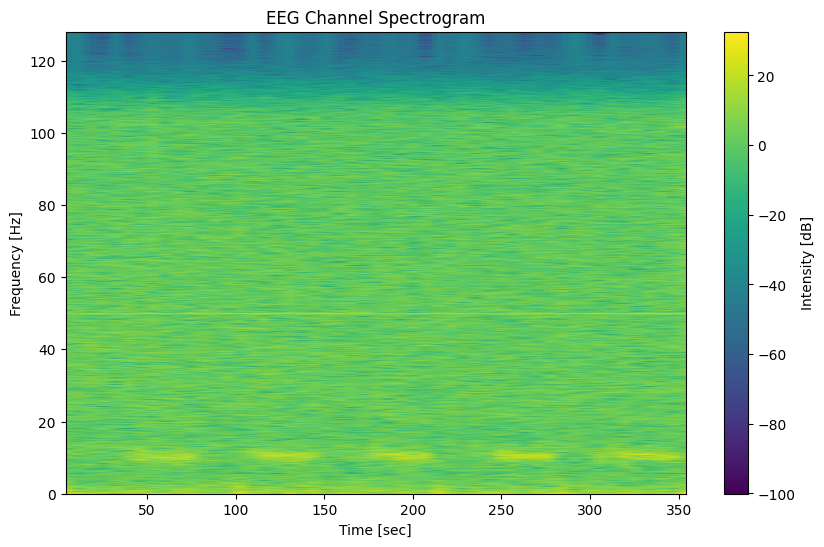

In [224]:
# Calculate and plot the spectrogram for the selected EEG channel
frequencies, times, Sxx = scipy.signal.spectrogram(
    eeg_channel_downsampled, fs_eeg_downsampled, window='hamming', nperseg=512*4)

plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('EEG Channel Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

Note:
- 50Hz Line
- Signal attenuation above ~120Hz
- Yellow blobs around 10Hz

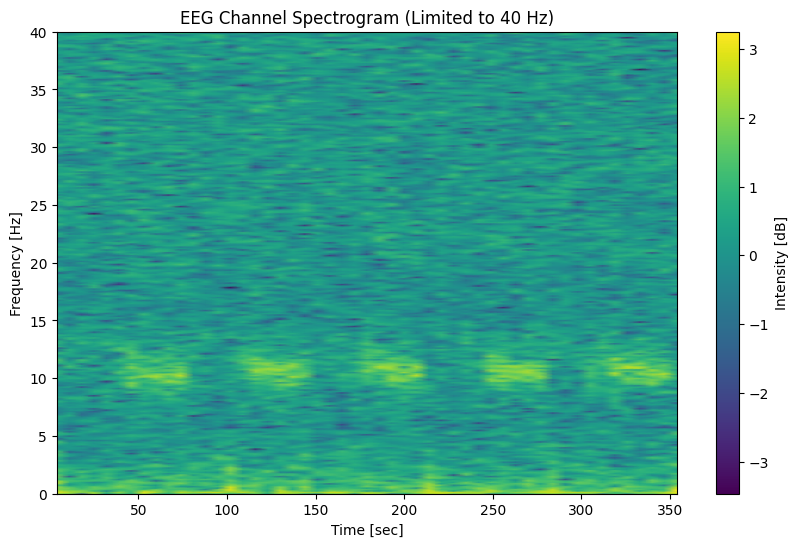

In [216]:
# Limit frequencies to 40 Hz
idx = frequencies <= 40
frequencies = frequencies[idx]
Sxx = Sxx[idx, :]

plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('EEG Channel Spectrogram (Limited to 40 Hz)')

plt.colorbar(label='Intensity [dB]')
plt.show()

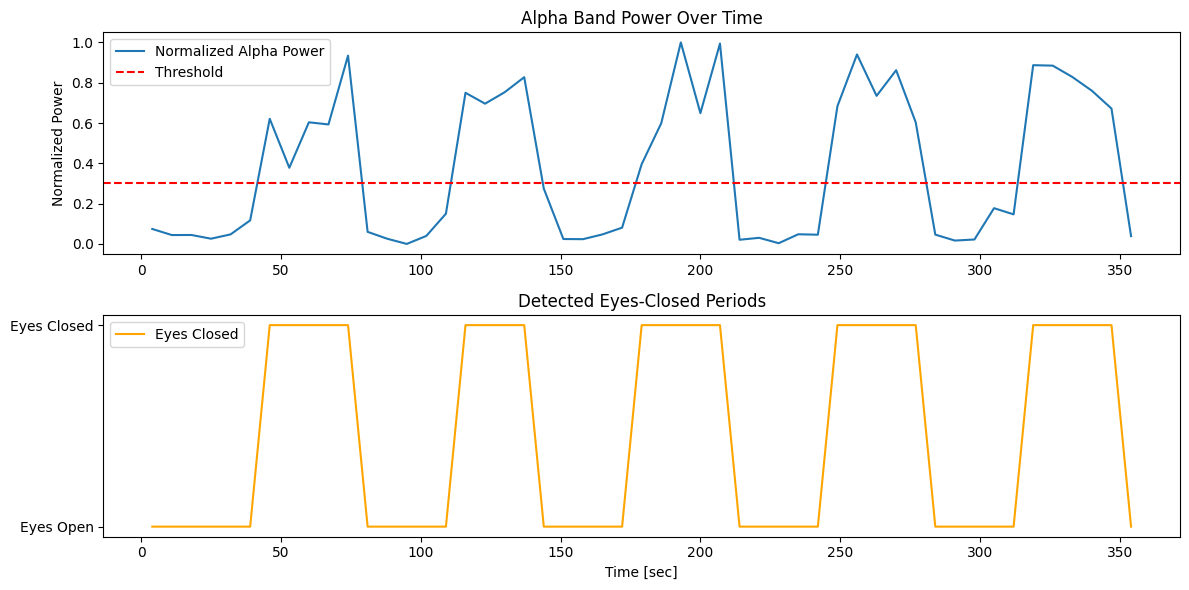

In [225]:
# Assuming 'frequencies', 'times', and 'Sxx' are already defined as in your spectrogram calculation
# First, identify the alpha band (8-13 Hz) indices
alpha_band_indices = (frequencies >= 8) & (frequencies <= 13)

# Calculate the mean power in the alpha band over time
alpha_power = np.mean(Sxx[alpha_band_indices, :], axis=0)

# Normalize the alpha power to make thresholding more robust
alpha_power_normalized = (alpha_power - np.min(alpha_power)) / (np.max(alpha_power) - np.min(alpha_power))

# Define a threshold for detecting eyes-closed (this may need tuning)
threshold = 0.3

# Detect eyes-closed periods
eyes_closed = alpha_power_normalized > threshold

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title('Alpha Band Power Over Time')
plt.plot(times, alpha_power_normalized, label='Normalized Alpha Power')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.ylabel('Normalized Power')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Detected Eyes-Closed Periods')
plt.plot(times, eyes_closed, label='Eyes Closed', color='orange')
plt.xlabel('Time [sec]')
plt.yticks([0, 1], ['Eyes Open', 'Eyes Closed'])
plt.legend()

plt.tight_layout()
plt.show()

# Summary

Before you do anything, visualize your data, make sure it looks sense and look for noise and outliers.

Pre-Processing Steps:
- Interpolate missing data
- Baseline Wander Removal, via high-pass filtering or other
- Power Line Interference Removal
- Filter to keep frequencies of interest
- Downsample
- Transform data into another space if needed (ex: Spectrogram)
- Window the data
- Remove windows with high-amplitude noise or other noise that could
not be removed.

Now, you can start training and AI model on your data!

Note that the pre-processing steps above are the basic but essential ones. There are more advanced techniques incuding Independent Component Analysis (ICA), Wavelet Decomposition, and much more. Besides, how to pre-process biomedical signals is an active area of research and development.

Scipy is a popular package, but there are other packages that can offer signal pre-processing techniques at an even higher-level interface. Consider using: neurokit2 and MNE-Python.

Neurokit: https://neuropsychology.github.io/NeuroKit/functions/index.html

MNE-Python: https://mne.tools/stable/index.html

